In [1]:
import os
#os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3" # or any {‘0’, ‘1’, ‘2’}
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
os.environ["TF_GPU_ALLOCATOR"]="cuda_malloc_async"
os.environ["TF_CPP_VMODULE"]="gpu_process_state=10,gpu_cudamallocasync_allocator=10"
import tensorflow_probability as tfp
from tensorflow.keras import layers, Model, models, metrics, optimizers
import keras
import logging
import tensorflow_datasets as tfds2
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import itertools
import gc
import os
import json
import inspect
import shutil
# tf.random.set_seed(1)

2025-02-16 13:30:12.119300: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739709012.143699   81361 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739709012.151022   81361 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-16 13:30:12.178703: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow version: 2.18.0
Num GPUs Available:  1


## Data loading + processing

### Geno Data

In [2]:
parental_geno_data = pd.read_csv("../data/parent_genos_ordered.csv")
child_geno_data = pd.read_csv("../data/all_child_genos_ordered.csv",
                               index_col=["pop", "individual"])
child_pheno_data = pd.read_csv("../data/pheno_data/pheno_oil_dist.csv", 
                               index_col=["pop", "individual"])
shared_index = child_pheno_data.index.intersection(child_geno_data.index)
child_pheno_data = child_pheno_data.reindex(shared_index)
child_geno_data = child_geno_data.reindex(shared_index).reset_index()
parent_pheno_data = pd.read_csv("../data/pheno_data/parents_oil.csv")


# Get population per sample, split populations into oop and train
pop_per_sample = child_geno_data["pop"].to_numpy()
test_pops = np.random.choice(np.unique(pop_per_sample), 6, replace = False)
train_eval_pops_idx = np.where(~np.isin(pop_per_sample, test_pops))[0]
eval_idx = np.random.choice(train_eval_pops_idx, 1000, replace = False)
train_idx = train_eval_pops_idx[~np.isin(train_eval_pops_idx, eval_idx)]
test_idx = np.where(np.isin(pop_per_sample, test_pops))[0]
pop_per_sample_train_eval = pop_per_sample[train_eval_pops_idx]
pop_per_sample_test = np.delete(pop_per_sample, train_eval_pops_idx)

assert ~np.any(np.isin(eval_idx, train_idx))
assert ~np.any(np.isin(eval_idx, test_idx))
assert ~np.any(np.isin(test_idx, train_idx))

In [3]:
all_geno_combs = list(itertools.product(["A", "T", "G", "C"], ["A", "T", "G", "C"])) + [("-", "-")]
all_geno_combs = np.unique(["".join(np.sort(cur_genos)) for cur_genos in all_geno_combs])

In [4]:
def split_data(data, train_idx = train_idx, eval_idx = eval_idx, test_idx = test_idx):
    return data[train_idx, ...], data[eval_idx, ...], data[test_idx, ...]

In [5]:
def normalize_traits(data):
    mean_mean, mean_std = data[:, 0].mean(), data[:, 0].std()
    sd_mean, sd_std = data[:, 1].mean(), data[:, 1].std()
    norm_data = (data - [mean_mean, sd_mean]) / [mean_std, sd_std]
    return norm_data, [mean_mean, mean_std], [sd_mean, sd_std]

In [6]:
p1_ids = child_geno_data['p1_id'].to_numpy()
p2_ids = child_geno_data['p2_id'].to_numpy()

# Parent 1 is technically always maize B73
# -> shuffle parent ids so model isnt fed same p1 input across all samples
p_genos_ids = np.stack([p1_ids, p2_ids], axis = 1)
[np.random.shuffle(cur_sub) for cur_sub in p_genos_ids]

## Extract parent phenotypes
def extract_phenos(ids, parent_data, extract_col):
    res = []
    for cur_id in ids:
        row_bools = parent_data["p_id"] == cur_id
        res.append(parent_data.loc[row_bools, extract_col].to_numpy().flatten())
    return np.array(res)

## Extract parental phenos from pandas df
p1_phenos = extract_phenos(p_genos_ids[:, 0], parent_pheno_data, ["mean_value", "sd_value"])
p2_phenos = extract_phenos(p_genos_ids[:, 1], parent_pheno_data, ["mean_value", "sd_value"])
child_pheno_np = child_pheno_data[["val_mean", "val_sd"]].to_numpy()

## Stack parental phenotypes, split to oop and train + eval
parents_phenos = np.stack([p1_phenos, p2_phenos], axis=1)
parents_phenos_np_train, parents_phenos_np_eval, parents_phenos_np_test = split_data(parents_phenos)
# parents_phenos_np_train = normalize_traits(parents_phenos_np_train)[0]
# parents_phenos_np_eval = normalize_traits(parents_phenos_np_eval)[0]
# parents_phenos_np_test =  normalize_traits(parents_phenos_np_test)[0]
child_pheno_np_train, child_pheno_np_eval, child_pheno_np_test = split_data(child_pheno_np)
# child_pheno_np_train, mean_denorm_train, sd_denorm_train = normalize_traits(child_pheno_np_train)
# child_pheno_np_eval, mean_denorm_eval, sd_denorm_eval = normalize_traits(child_pheno_np_eval)
# child_pheno_np_test, mean_denorm_test, sd_denorm_test = normalize_traits(child_pheno_np_test)

## Extract parental genos, split to oop and train + eval
parental_geno_red = parental_geno_data.iloc[:, 1:]
p1_genos_np = extract_phenos(p_genos_ids[:, 0], parental_geno_red, parental_geno_red.columns[:-1])
p2_genos_np = extract_phenos(p_genos_ids[:, 1], parental_geno_red, parental_geno_red.columns[:-1])
p_genos_np = np.stack([p1_genos_np, p2_genos_np], axis = 1)
p_genos_np_train, p_genos_np_eval, p_genos_np_test = split_data(p_genos_np)

# Split child geno types into train + (in population) evaluation error and OOP
# IP data == eval, OOP == test
child_geno_np_train, child_geno_np_eval, child_geno_np_test = split_data(child_geno_data.iloc[:, 2:-2].to_numpy())
child_geno_np = child_geno_data.iloc[:, 2:-2].to_numpy()

In [7]:
# Convert data into one hot encodings and stack to tensors

def one_hot_encode(data, vocab = all_geno_combs):
    encoded_list = [np.float16(data == cur_class) for cur_class in vocab]
    return tf.stack(encoded_list, axis = -1)


child_geno_tensor_train = one_hot_encode(child_geno_np_train)
p_genos_tensor_train = one_hot_encode(p_genos_np_train)

child_geno_tensor_eval = one_hot_encode(child_geno_np_eval)
p_genos_tensor_eval = one_hot_encode(p_genos_np_eval)

child_geno_tensor_test = one_hot_encode(child_geno_np_test)
p_genos_tensor_test = one_hot_encode(p_genos_np_test)

child_geno_tensor = one_hot_encode(child_geno_np)
p_genos_tensor = one_hot_encode(p_genos_np)

I0000 00:00:1739709032.836279   81361 gpu_process_state.cc:201] Using CUDA malloc Async allocator for GPU: 0
I0000 00:00:1739709032.927260   81361 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4699 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0, compute capability: 6.1


In [8]:
# train_dataset -> actual training
# eval -> test dataset without seeing children, shared parents with train_dataset (IP)
# test_dataset -> test dataset without seeing children + parents (OOP)

geno_train_dataset = tf.data.Dataset.from_tensor_slices((p_genos_tensor_train, child_geno_tensor_train))
pheno_train_dataset = tf.data.Dataset.from_tensor_slices((parents_phenos_np_train, child_pheno_np_train))
train_dataset = tf.data.Dataset.zip((geno_train_dataset, pheno_train_dataset))
train_dataset = train_dataset.shuffle(int(1e6))
train_dataset = train_dataset.batch(256, drop_remainder=True)

geno_test_dataset = tf.data.Dataset.from_tensor_slices((p_genos_tensor_test, child_geno_tensor_test))
pheno_test_dataset = tf.data.Dataset.from_tensor_slices((parents_phenos_np_test, child_pheno_np_test))
test_dataset = tf.data.Dataset.zip((geno_test_dataset, pheno_test_dataset))
test_dataset = test_dataset.shuffle(buffer_size=int(1e6))
test_dataset = test_dataset.batch(256, drop_remainder=True)

## Model definition

In [9]:
# Moved defintions to separate python scripts
# inspect_dir = "./data/reg_vae/lim_kl_scale_01_reg_w_closs_smooth/"
files_to_load = ["reg_vae_helpers.py", "cur_encoder.py", "cur_decoder.py",
    "geno_to_trait_model.py", "regression_vae.py", "custom_lr_on_callback.py"]
for cur_file in files_to_load:
    execfile(cur_file)
cur_base_dir = "./results/_proj_parents/"
if not os.path.isdir(cur_base_dir):
    os.mkdir(cur_base_dir)

/home/max/miniconda3/envs/tf-wsl2/lib/python3.9/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


## Individual Models

In [10]:
for batch in train_dataset:
    test_batch = batch
    break
reg_vae_model = reg_vae(100, 5, 5)
reg_vae_model.compile(run_eagerly = False)
_ = reg_vae_model((test_batch[0],test_batch[1][0]))
var_imp = VarImpVIANN(verbose=True)
# reduce_reg_lr = c_ReduceLROnPlateau(monitor='reg_loss', factor=0.5, patience=15, min_lr=1e-6,
#     optimizer = reg_vae_model.reg_vae_opt, verbose = 1, start_epoch = 50)
# reduce_rec_lr = c_ReduceLROnPlateau(monitor='rec_loss', factor=0.5, patience=10, min_lr=1e-6,
#     optimizer = reg_vae_model.vae_opt, verbose = 1, start_epoch = 150)
reduce_lr = c_ReduceLROnPlateau(monitor='total_loss', factor=0.5, patience=10, min_lr=1e-6,
    optimizer = reg_vae_model.total_optimizer, verbose = 1, start_epoch = 50)

/home/max/miniconda3/envs/tf-wsl2/lib/python3.9/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'decoder', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/home/max/miniconda3/envs/tf-wsl2/lib/python3.9/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'reg_vae', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
I0000 00:00:1739709050.283138   81416 cuda_dnn.cc:529] Loaded cuDNN version 90300


In [ ]:
# higher kl loss -> worse reconstruction
    # 0 reg loss, 0.1 kl loss -> val cat acc 72%
    # 0 reg loss, 0.0 kl loss -> val cat acc 72%, 93 % train cat acc, harder overfit -> adding reg
        # 0.2 f_drop: no learning
        # 0.1 f_drop: no learning
        # 0.05 f_drop: no learning
        # 0.1 drop: val cat acc 72%, 93 % train cat acc, harder overfit -> adding reg
        # 0.2 drop: setting kl scale to 0.1 so logvar doesnt go crazy, val cat acc 73%, 88 % train cat acc
        # 0.3 drop: val cat acc 73+%, 86 % train cat acc
#           + 1e-2 l2 reg:
        # 0.5 drop: 
res = train_and_get_results(reg_vae_model, epochs = 200, track_activations = False,
    train_dataset = train_dataset, test_dataset = test_dataset,
    base_dir = cur_base_dir, files_to_backup = files_to_load,
    callbacks = [], save_weights = False) # reduce_reg_lr, reduce_rec_lr, reduce_lr


Epoch 1/200


2025-02-16 13:31:59.846404: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-02-16 13:32:03.840815: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1 train metrics:
kl_loss: 18.491901397705078, kl_scale: 0.10000000894069672, reg_loss: 74.89646911621094, epoch: 0.0, cat_acc: 0.5847179293632507, rec_loss: 1.5409867763519287, mean_deviation: 83.20174407958984, sd_deviation: 66.5911865234375, total_loss: 78.28663635253906, 0_acc: 0.0303223617374897, 1_acc: 0.6237455010414124, 2_acc: 0.011024007573723793, 3_acc: 0.009495674632489681, 4_acc: 0.018567638471722603, 5_acc: 0.6246867775917053, 6_acc: 0.0060326470993459225, 7_acc: 0.008670912124216557, 8_acc: 0.6107620000839233, 9_acc: 0.012330456636846066, 10_acc: 0.6226877570152283, 
Epoch 1 val metrics:
kl_loss: 165.280029296875, kl_scale: 1.0, reg_loss: 73.21702575683594, epoch: 0.0, cat_acc: 0.4999966025352478, rec_loss: 1.5359169244766235, mean_deviation: 83.34152221679688, sd_deviation: 63.09251403808594, total_loss: 240.03297424316406, 0_acc: 0.05510116368532181, 1_acc: 0.5891509652137756, 2_acc: 0.14517436921596527, 3_acc: 0.024358641356229782, 4_acc: 0.0, 5_acc: 0.48548832535

2025-02-16 13:32:20.916053: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 2 train metrics:
kl_loss: 1011.4323120117188, kl_scale: 0.10000000894069672, reg_loss: 74.72374725341797, epoch: 1.0, cat_acc: 0.5984713435173035, rec_loss: 1.467112421989441, mean_deviation: 83.1233139038086, sd_deviation: 66.32416534423828, total_loss: 177.33409118652344, 0_acc: 0.02413487434387207, 1_acc: 0.6391842365264893, 2_acc: 0.005626223050057888, 3_acc: 0.006045269314199686, 4_acc: 0.0095836091786623, 5_acc: 0.6395351886749268, 6_acc: 0.0024906599428504705, 7_acc: 0.00447124196216464, 8_acc: 0.625410258769989, 9_acc: 0.004917629528790712, 10_acc: 0.6376144289970398, 
Epoch 2 val metrics:
kl_loss: 3192.77685546875, kl_scale: 1.0, reg_loss: 72.04841613769531, epoch: 1.0, cat_acc: 0.5875935554504395, rec_loss: 1.3335353136062622, mean_deviation: 83.39453125, sd_deviation: 60.70231628417969, total_loss: 3266.15869140625, 0_acc: 0.024795278906822205, 1_acc: 0.6481757164001465, 2_acc: 0.11493288725614548, 3_acc: 0.0012658227933570743, 4_acc: 0.0, 5_acc: 0.553080677986145, 6_a

2025-02-16 13:32:29.320571: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 4 train metrics:
kl_loss: 1012.4228515625, kl_scale: 0.10000000894069672, reg_loss: 74.7904281616211, epoch: 3.0, cat_acc: 0.6077979803085327, rec_loss: 1.3379138708114624, mean_deviation: 83.100830078125, sd_deviation: 66.48004150390625, total_loss: 177.37063598632812, 0_acc: 0.015166123397648335, 1_acc: 0.6509193181991577, 2_acc: 0.004395604599267244, 3_acc: 0.0020385209936648607, 4_acc: 0.008919722400605679, 5_acc: 0.6497913002967834, 6_acc: 0.0008882572292350233, 7_acc: 0.001692391000688076, 8_acc: 0.6333492398262024, 9_acc: 0.0022123893722891808, 10_acc: 0.6493369340896606, 
Epoch 4 val metrics:
kl_loss: 823.0277099609375, kl_scale: 1.0, reg_loss: 71.52452087402344, epoch: 3.0, cat_acc: 0.603256106376648, rec_loss: 1.4202430248260498, mean_deviation: 83.41455078125, sd_deviation: 59.634498596191406, total_loss: 895.9724731445312, 0_acc: 0.01414122898131609, 1_acc: 0.6993213295936584, 2_acc: 0.0, 3_acc: 0.0, 4_acc: 0.0, 5_acc: 0.6577550768852234, 6_acc: 0.0, 7_acc: 0.0, 8_acc

2025-02-16 13:32:46.245058: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 8 train metrics:
kl_loss: 3076.468505859375, kl_scale: 0.10000000894069672, reg_loss: 74.66529846191406, epoch: 7.0, cat_acc: 0.6223005652427673, rec_loss: 1.1063807010650635, mean_deviation: 82.9964599609375, sd_deviation: 66.3341293334961, total_loss: 383.4185485839844, 0_acc: 0.004160200245678425, 1_acc: 0.6829134225845337, 2_acc: 0.0009825595188885927, 3_acc: 0.00042274361476302147, 4_acc: 0.0, 5_acc: 0.6580406427383423, 6_acc: 0.0, 7_acc: 0.0, 8_acc: 0.6391054391860962, 9_acc: 0.0, 10_acc: 0.668752908706665, 
Epoch 8 val metrics:
kl_loss: 4579.5048828125, kl_scale: 1.0, reg_loss: 74.52606201171875, epoch: 7.0, cat_acc: 0.616659939289093, rec_loss: 1.0268635749816895, mean_deviation: 83.33365631103516, sd_deviation: 65.71846008300781, total_loss: 4655.0576171875, 0_acc: 0.0, 1_acc: 0.8548614382743835, 2_acc: 0.0, 3_acc: 0.0, 4_acc: 0.0, 5_acc: 0.6738256812095642, 6_acc: 0.0, 7_acc: 0.0, 8_acc: 0.5542583465576172, 9_acc: 0.0, 10_acc: 0.5408546328544617, 
Epoch 9/200
Epoch 9 tr

2025-02-16 13:33:18.838706: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 16 train metrics:
kl_loss: 29510.275390625, kl_scale: 0.10000000894069672, reg_loss: 72.8048324584961, epoch: 15.0, cat_acc: 0.6324037313461304, rec_loss: 0.8884276747703552, mean_deviation: 82.51374816894531, sd_deviation: 63.09591293334961, total_loss: 3024.720947265625, 0_acc: 0.0009779632091522217, 1_acc: 0.6980125904083252, 2_acc: 0.0004892367869615555, 3_acc: 0.0, 4_acc: 0.0, 5_acc: 0.6698134541511536, 6_acc: 0.0, 7_acc: 0.0, 8_acc: 0.6439248323440552, 9_acc: 0.0, 10_acc: 0.681027889251709, 
Epoch 16 val metrics:
kl_loss: 28455.3828125, kl_scale: 1.0, reg_loss: 73.07398223876953, epoch: 15.0, cat_acc: 0.6099059581756592, rec_loss: 0.962404727935791, mean_deviation: 83.3914566040039, sd_deviation: 62.756507873535156, total_loss: 28529.421875, 0_acc: 0.0, 1_acc: 0.9469982385635376, 2_acc: 0.0, 3_acc: 0.0, 4_acc: 0.0, 5_acc: 0.7828993201255798, 6_acc: 0.0, 7_acc: 0.0, 8_acc: 0.4004592001438141, 9_acc: 0.0, 10_acc: 0.45773690938949585, 
Epoch 17/200
Epoch 17 train metrics:
kl_l

2025-02-16 13:34:25.408321: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 32 train metrics:
kl_loss: 13054.1806640625, kl_scale: 0.10000000894069672, reg_loss: 73.56254577636719, epoch: 31.0, cat_acc: 0.6388084292411804, rec_loss: 0.8203961253166199, mean_deviation: 82.6622085571289, sd_deviation: 64.462890625, total_loss: 1379.8011474609375, 0_acc: 0.008891438134014606, 1_acc: 0.6993898749351501, 2_acc: 0.0048828125, 3_acc: 0.00014086491137277335, 4_acc: 0.0, 5_acc: 0.6755405068397522, 6_acc: 0.000711237546056509, 7_acc: 0.00033896006061695516, 8_acc: 0.6531311869621277, 9_acc: 0.0007383706397376955, 10_acc: 0.6903765797615051, 
Epoch 32 val metrics:
kl_loss: 9218.529296875, kl_scale: 1.0, reg_loss: 74.22299194335938, epoch: 31.0, cat_acc: 0.5895432233810425, rec_loss: 1.050255298614502, mean_deviation: 83.3415298461914, sd_deviation: 65.10444641113281, total_loss: 9293.802734375, 0_acc: 0.05462490767240524, 1_acc: 0.43894609808921814, 2_acc: 0.0, 3_acc: 0.0, 4_acc: 0.0, 5_acc: 0.7196478247642517, 6_acc: 0.0, 7_acc: 0.001451730029657483, 8_acc: 0.8125

In [ ]:
# Load stored model
# Moved defintions to separate python scripts
files_to_load = ["reg_vae_helpers.py", "cur_encoder.py", "cur_decoder.py",
    "geno_to_trait_model.py", "regression_vae.py"]
for cur_file in files_to_load:
    execfile(cur_file)

loaded_model = keras.models.load_model(
    cur_base_dir + "/model.keras",
    custom_objects = {"encoder" : encoder, "decoder" : decoder, "reg_vae" : reg_vae,
        "elbo_loss" : elbo_loss, "rec_loss_fn" : rec_loss_fn, "reg_loss_fn" : reg_loss_fn, "feature_drop_layer": feature_drop_layer}
)
# cur_model = loaded_model

/home/max/miniconda3/envs/tf-wsl2/lib/python3.9/site-packages/keras/src/saving/serialization_lib.py:730: UserWarning: Model 'reg_vae' had a build config, but the model cannot be built automatically in `build_from_config(config)`. You should implement `def build_from_config(self, config)`, and you might also want to implement the method  that generates the config at saving time, `def get_build_config(self)`. The method `build_from_config()` is meant to create the state of the model (i.e. its variables) upon deserialization.
  instance.build_from_config(build_config)
/home/max/miniconda3/envs/tf-wsl2/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 2 variables whereas the saved optimizer has 270 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/home/max/miniconda3/envs/tf-wsl2/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loa

# Grid testing
* Deprecated, need to rerun once satisfying VAE structure found
* Test hyperparamters in grid like fashion

In [ ]:

def fit_per_para(encoder_w, decoder_d, epochs = 100):
    print("###########################################")
    print(f"current encoder width: {encoder_w}")
    print(f"current decoder depth: {decoder_d}")
    true_classes = np.argmax(geno_tensor, axis = 1).reshape((-1))

    # used for focal loss
    inv_class_frequencies = 1 - ((np.unique(true_classes, return_counts=True)[1] / len(true_classes)))

    focal_loss = tf.keras.losses.CategoricalCrossentropy(axis = 1,
                                                          from_logits=False)

    focal_optimizer = optimizers.Lion(learning_rate=1e-4)
    model = autoencoder(100, encoder_width=encoder_w, decoder_depth=decoder_d)
    model.compile(optimizer=focal_optimizer, loss = focal_loss, run_eagerly=False,
                      metrics=[metrics.CategoricalAccuracy()])
    model_train_loss = model.fit(train_dataset, epochs=epochs, shuffle=True,
                                 validation_data = test_dataset)
    true_classes = np.argmax(test_labels, axis = 1).reshape((-1))
    pred_classes = np.argmax(model(test_labels), axis = 1).reshape((-1))
    class_acc = [np.sum((pred_classes == true_classes) & (pred_classes == cur_class))/
           np.sum(true_classes == cur_class) for cur_class in np.unique(true_classes)]
    print(class_acc)
    print(pd.crosstab(pd.Series(pred_classes, name="Predicted"), pd.Series(true_classes, name="Actual")))
    out = [class_acc, model_train_loss]
    del model
    gc.collect()
    tf.keras.backend.clear_session()
    gc.collect()

    return out

In [ ]:
paras = list(itertools.product(list(range(5,0,-1)),list(range(5,0, -1))))

In [ ]:
res_per_para = [fit_per_para(cur_paras[0], cur_paras[1], epochs = 100) for cur_paras in paras]

###########################################
encoder_w: 5
decoder_d: 5
Epoch 1/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 144ms/step - categorical_accuracy: 0.0014 - loss: 1.1271 - val_categorical_accuracy: 0.0020 - val_loss: 1.0366
Epoch 2/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - categorical_accuracy: 0.0020 - loss: 1.0030 - val_categorical_accuracy: 6.5104e-04 - val_loss: 0.9019
Epoch 3/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - categorical_accuracy: 0.0025 - loss: 0.8578 - val_categorical_accuracy: 0.0290 - val_loss: 0.7626
Epoch 4/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - categorical_accuracy: 0.0299 - loss: 0.7604 - val_categorical_accuracy: 0.0280 - val_loss: 0.7459
Epoch 5/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - categorical_accuracy: 0.0287 - loss: 0.7447 - val_categorical_accuracy: 0.0238 - val_loss: 0.7372
Epoch 6/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - categorical_accuracy: 0.0256 - loss: 0.7354 - val_categorical_accuracy: 0.0280 - val_loss: 0.7304
Epoch 7/200


In [ ]:
res_dict = {str(paras[cur_para_id]):[res_per_para[cur_para_id][0], res_per_para[cur_para_id][1].history] for cur_para_id in range(len(paras))}
res_out = open(cur_base_dir + "grid_test.txt", "w")
res_out.write(json.dumps(res_dict))
res_out.close()

In [ ]:
res_deep_encoder_thining = json.loads(open(cur_base_dir + "grid_test.txt").read())
dt_keys = list(res_deep_encoder_thining.keys())
dt_acc = [res_deep_encoder_thining[cur_dict][0] for cur_dict in dt_keys]
dt_train = [res_deep_encoder_thining[cur_dict][1]["loss"] for cur_dict in dt_keys]
dt_val = [res_deep_encoder_thining[cur_dict][1]["val_loss"] for cur_dict in dt_keys]

In [ ]:
dt_acc_df = pd.DataFrame(np.array(dt_acc))
dt_acc_df["fit"] = dt_keys

dt_train_df = pd.DataFrame(np.array(dt_train))
dt_train_df["fit"] = dt_keys

dt_train_df["loss_type"] = "train"
dt_val_df = pd.DataFrame(np.array(dt_val))
dt_val_df["fit"] = dt_keys
dt_val_df["loss_type"] = "test"
dt_train_df = pd.concat((dt_train_df, dt_val_df))

In [ ]:
dt_train_df.to_csv(cur_base_dir + "model_5_train.csv", sep=",")
dt_acc_df.to_csv(cur_base_dir + "model_5_acc.csv", sep=",")

# VAE model analysis

### Input to encoding correlation

In [124]:
full_test_tensor = tf.concat([
            p_genos_tensor_test, tf.expand_dims(child_geno_tensor_test, 1)],
            axis = 1)
# reg_vae_model.encoder(full_test_tensor)
summed_test_tensor = tf.reduce_sum(full_test_tensor, axis = [-1, 1])

In [126]:
np.unique(summed_test_tensor)

array([3.], dtype=float16)

In [18]:
encoder_model = reg_vae_model.encoder
decoder_model = reg_vae_model.decoder
train_mean, train_logvar = encoder_model(tf.concat([p_genos_tensor_train, tf.expand_dims(child_geno_tensor_train, 1)], axis = 1))
train_embedding = reg_vae_model.sample_z(train_mean, train_logvar)
train_pred = decoder_model(p_genos_tensor_train, train_embedding)
train_pred = np.argmax(train_pred, axis = -1)
train_pred_df = pd.DataFrame(train_pred)
train_pred_df["d_type"] = "pred"
truth_df = pd.DataFrame(np.argmax(child_geno_tensor_train[:, 0, :], axis = -1))
truth_df["d_type"] = "truth"
full_train_df = pd.concat([train_pred_df, truth_df], axis = 0)
full_train_df.to_csv(cur_base_dir + "train_pop_pred.csv")

mean_embed_df = pd.DataFrame(train_mean.numpy())
mean_embed_df["individual"] = child_geno_data.loc[train_idx, "individual"].to_numpy()
mean_embed_df["pop"] = child_geno_data.loc[train_idx, "pop"].to_numpy()
mean_embed_df["p1_id"] = child_geno_data.loc[train_idx, "p1_id"].to_numpy()
mean_embed_df["p2_id"] = child_geno_data.loc[train_idx, "p2_id"].to_numpy()
mean_embed_df.to_csv(cur_base_dir + "train_pop_mean_embed.csv")

logvar_embed_df = pd.DataFrame(train_logvar.numpy())
logvar_embed_df["individual"] = child_geno_data.loc[train_idx, "individual"].to_numpy()
logvar_embed_df["pop"] = child_geno_data.loc[train_idx, "pop"].to_numpy()
logvar_embed_df["p1_id"] = child_geno_data.loc[train_idx, "p1_id"].to_numpy()
logvar_embed_df["p2_id"] = child_geno_data.loc[train_idx, "p2_id"].to_numpy()
logvar_embed_df.to_csv(cur_base_dir + "train_pop_logvar_embed.csv")

In [19]:
test_mean, test_logvar = encoder_model(tf.concat([p_genos_tensor_test, tf.expand_dims(child_geno_tensor_test, 1)], axis = 1))
test_embedding = reg_vae_model.sample_z(test_mean, test_logvar)
test_pred = decoder_model(p_genos_tensor_test, test_embedding)
test_pred = np.argmax(test_pred, axis = -1)
test_pred_df = pd.DataFrame(test_pred)
test_pred_df["d_type"] = "pred"
truth_df = pd.DataFrame(np.argmax(child_geno_tensor_test[:, 0, :], axis = -1))
truth_df["d_type"] = "truth"
full_test_df = pd.concat([test_pred_df, truth_df], axis = 0)
full_test_df.to_csv(cur_base_dir + "new_pop_pred.csv")

mean_embed_df = pd.DataFrame(train_mean.numpy())
mean_embed_df["individual"] = child_geno_data.loc[train_idx, "individual"].to_numpy()
mean_embed_df["pop"] = child_geno_data.loc[train_idx, "pop"].to_numpy()
mean_embed_df["p1_id"] = child_geno_data.loc[train_idx, "p1_id"].to_numpy()
mean_embed_df["p2_id"] = child_geno_data.loc[train_idx, "p2_id"].to_numpy()
mean_embed_df.to_csv(cur_base_dir + "train_pop_mean_embed.csv")

logvar_embed_df = pd.DataFrame(train_logvar.numpy())
logvar_embed_df["individual"] = child_geno_data.loc[train_idx, "individual"].to_numpy()
logvar_embed_df["pop"] = child_geno_data.loc[train_idx, "pop"].to_numpy()
logvar_embed_df["p1_id"] = child_geno_data.loc[train_idx, "p1_id"].to_numpy()
logvar_embed_df["p2_id"] = child_geno_data.loc[train_idx, "p2_id"].to_numpy()
logvar_embed_df.to_csv(cur_base_dir + "train_pop_logvar_embed.csv")

In [22]:
# Load stored model
# Moved defintions to separate python scripts
files_to_load = ["reg_vae_helpers.py", "cur_encoder.py", "cur_decoder.py",
    "reg_autoencoder.py", "geno_to_trait_model.py", "regression_vae.py"]
for cur_file in files_to_load:
    execfile(cur_file)

loaded_model = keras.models.load_model(
    "./data/reg_vae/lim_kl_scale_001/model.keras",
    custom_objects = {"encoder" : encoder, "decoder" : decoder, "reg_vae" : autoencoder,
        "elbo_loss" : elbo_loss, "rec_loss_fn" : rec_loss_fn, "reg_loss_fn" : reg_loss_fn, "feature_drop_layer": feature_drop_layer}
)
cur_model = loaded_model

/home/max/miniconda3/envs/tf-wsl2/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 2 variables whereas the saved optimizer has 350 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/home/max/miniconda3/envs/tf-wsl2/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 2 variables whereas the saved optimizer has 646 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


# Prediction per population

In [15]:
geno_np_arr = np.stack(geno_np_layers, axis = -1)

In [ ]:
# Loop through populations in dataset and store genotype reconstruction accuracies
def class_acc_per_pop(model, data, sample_pops):
    pops = []
    class_accs_in_oop = {class_id: [] for class_id in range(data.shape[-1])}
    for cur_pop in np.unique(pop_per_sample):
        pop_idx = sample_pops == cur_pop
        pops.append(cur_pop)
        cur_geno_tensor = data[pop_idx, ...]
        pred = model(cur_geno_tensor)
        true_classes = tf.argmax(cur_geno_tensor[:, 0, ...], axis = -1)
        for class_id in range(pred.shape[-1]):

            class_pred = tf.equal(tf.argmax(pred, axis = -1), class_id)
            class_y = tf.equal(true_classes, class_id)
            correct_pred = tf.cast(tf.logical_and(class_pred, class_y), tf.int32)

            acc = tf.reduce_sum(correct_pred)/tf.reduce_sum(tf.cast(class_y, tf.int32))
            class_accs_in_oop[class_id].append(acc.numpy())    
    res = pd.DataFrame(class_accs_in_oop)
    res["pop"] = pops
    return res

In [ ]:
res_df = class_acc_per_pop(cur_model, geno_np_arr, pop_per_sample)
res_df["data_type"] = "train"
res_df.loc[np.isin(res_df["pop"], test_pops), "data_type"] = "oop"

In [ ]:
eval_df = class_acc_per_pop(cur_model, geno_tensor_eval.numpy(), eval_pops)
eval_df["data_type"] = "eval"

In [54]:
pd.concat([res_df, eval_df]).to_csv("./data/var_autoencoder/with_unseen_children_vanilla_vae/acc_per_pop.csv")

# Prediction per trait loop

In [26]:
def get_trait_performance(trait_name, rep_per_trait = 5, epochs = 150):
    parental_geno_data = pd.read_csv("../data/parent_genos_ordered.csv")
    child_geno_data = pd.read_csv("../data/all_child_genos_ordered.csv",
                                   index_col=["pop", "individual"])
    child_pheno_data = pd.read_csv(f"../data/pheno_data/pheno_{trait_name}_dist.csv", 
                                   index_col=["pop", "individual"])
    shared_index = child_pheno_data.index.intersection(child_geno_data.index)
    child_pheno_data = child_pheno_data.reindex(shared_index)
    child_geno_data = child_geno_data.reindex(shared_index).reset_index()
    parent_pheno_data = pd.read_csv(f"../data/pheno_data/parents_{trait_name}.csv")

    for cur_rep_id in range(rep_per_trait):
        cur_base_dir = "./res_per_trait/" + trait_name + str(cur_rep_id) + "/"
        if not os.path.isdir(cur_base_dir):
            os.mkdir(cur_base_dir)

        # Get population per sample, split populations into oop and train
        pop_per_sample = child_geno_data["pop"].to_numpy()
        test_pops = np.random.choice(np.unique(pop_per_sample), 6, replace = False)
        train_eval_pops_idx = np.where(~np.isin(pop_per_sample, test_pops))[0]
        eval_idx = np.random.choice(train_eval_pops_idx, 1000, replace = False)
        train_idx = train_eval_pops_idx[~np.isin(train_eval_pops_idx, eval_idx)]
        test_idx = np.where(np.isin(pop_per_sample, test_pops))[0]
        pop_per_sample_train_eval = pop_per_sample[train_eval_pops_idx]
        pop_per_sample_test = np.delete(pop_per_sample, train_eval_pops_idx)

        assert ~np.any(np.isin(eval_idx, train_idx))
        assert ~np.any(np.isin(eval_idx, test_idx))
        assert ~np.any(np.isin(test_idx, train_idx))
        p1_ids = child_geno_data['p1_id'].to_numpy()
        p2_ids = child_geno_data['p2_id'].to_numpy()

        # Parent 1 is technically always maize B73
        # -> shuffle parent ids so model isnt fed same p1 input across all samples
        p_genos_ids = np.stack([p1_ids, p2_ids], axis = 1)
        [np.random.shuffle(cur_sub) for cur_sub in p_genos_ids]

        ## Extract parent phenotypes
        def extract_phenos(ids, parent_data, extract_col):
            res = []
            for cur_id in ids:
                row_bools = parent_data["p_id"] == cur_id
                res.append(parent_data.loc[row_bools, extract_col].to_numpy().flatten())
            return np.array(res)

        ## Extract parental phenos from pandas df
        p1_phenos = extract_phenos(p_genos_ids[:, 0], parent_pheno_data, ["mean_value", "sd_value"])
        p2_phenos = extract_phenos(p_genos_ids[:, 1], parent_pheno_data, ["mean_value", "sd_value"])
        child_pheno_np = child_pheno_data[["val_mean", "val_sd"]].to_numpy()

        ## Stack parental phenotypes, split to oop and train + eval
        parents_phenos = np.stack([p1_phenos, p2_phenos], axis=1)
        parents_phenos_np_train, parents_phenos_np_eval, parents_phenos_np_test = split_data(parents_phenos)
        child_pheno_np_train, child_pheno_np_eval, child_pheno_np_test = split_data(child_pheno_np)

        ## Extract parental genos, split to oop and train + eval
        parental_geno_red = parental_geno_data.iloc[:, 1:]
        p1_genos_np = extract_phenos(p_genos_ids[:, 0], parental_geno_red, parental_geno_red.columns[:-1])
        p2_genos_np = extract_phenos(p_genos_ids[:, 1], parental_geno_red, parental_geno_red.columns[:-1])
        p_genos_np = np.stack([p1_genos_np, p2_genos_np], axis = 1)
        p_genos_np_train, p_genos_np_eval, p_genos_np_test = split_data(p_genos_np)

        # Split child geno types into train + (in population) evaluation error and OOP
        # IP data == eval, OOP == test
        child_geno_np_train, child_geno_np_eval, child_geno_np_test = split_data(child_geno_data.iloc[:, 2:-2].to_numpy())
        child_geno_np = child_geno_data.iloc[:, 2:-2].to_numpy()

        # Convert data into one hot encodings and stack to tensors

        child_geno_tensor_train = one_hot_encode(child_geno_np_train)
        p_genos_tensor_train = one_hot_encode(p_genos_np_train)

        child_geno_tensor_eval = one_hot_encode(child_geno_np_eval)
        p_genos_tensor_eval = one_hot_encode(p_genos_np_eval)

        child_geno_tensor_test = one_hot_encode(child_geno_np_test)
        p_genos_tensor_test = one_hot_encode(p_genos_np_test)

        child_geno_tensor = one_hot_encode(child_geno_np)
        p_genos_tensor = one_hot_encode(p_genos_np)

        geno_train_dataset = tf.data.Dataset.from_tensor_slices((p_genos_tensor_train, child_geno_tensor_train))
        pheno_train_dataset = tf.data.Dataset.from_tensor_slices((parents_phenos_np_train, child_pheno_np_train))
        train_dataset = tf.data.Dataset.zip((geno_train_dataset, pheno_train_dataset))
        train_dataset = train_dataset.shuffle(int(1e6))
        train_dataset = train_dataset.batch(256, drop_remainder=True)

        geno_test_dataset = tf.data.Dataset.from_tensor_slices((p_genos_tensor_test, child_geno_tensor_test))
        pheno_test_dataset = tf.data.Dataset.from_tensor_slices((parents_phenos_np_test, child_pheno_np_test))
        test_dataset = tf.data.Dataset.zip((geno_test_dataset, pheno_test_dataset))
        test_dataset = test_dataset.shuffle(buffer_size=int(1e6))
        test_dataset = test_dataset.batch(256, drop_remainder=True)
        for batch in train_dataset:
            test_batch = batch
            break
        reg_vae_model = reg_vae(100, 5, 5)
        reg_vae_model.compile(run_eagerly = False)
        _ = reg_vae_model((test_batch[0],test_batch[1][0]))
        var_imp = VarImpVIANN(verbose=True)
        res = train_and_get_results(reg_vae_model, epochs = epochs,
            base_dir = cur_base_dir, files_to_backup = files_to_load,
            callbacks = [var_imp]) #
        scores = pd.DataFrame({"s2" : var_imp.s2, "var_scores" : var_imp.varScores})
        scores.to_csv(cur_base_dir + "scores.csv")
        del reg_vae_model
        del var_imp

/home/max/miniconda3/envs/tf-wsl2/lib/python3.9/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


example input x: (256, 1144, 11)
example input x: (256, 1144, 11)


/home/max/miniconda3/envs/tf-wsl2/lib/python3.9/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'reg_vae', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


geno_shape: (1144, 11)
VIANN version 1.0 (Wellford + Mean) update per epoch

Epoch 1/5
example input x: (256, 1144, 11)
example input x: (256, 1144, 11)
example input x: (256, 1144, 11)
Epoch 1 train metrics:
kl_loss: 6.778693199157715, kl_scale: 0.10000000894069672, elbo_rec: 2.121042490005493, elbo_reg: 4683.650390625, reg_loss: 4682.97265625, epoch: 0.0, cat_acc: 0.5866947770118713, reconstruction_loss: 1.4431729316711426, mean_deviation: 4427.66357421875, sd_deviation: 4938.28125, 0_acc: 0.022710531949996948, 1_acc: 0.6353140473365784, 2_acc: 0.004521328955888748, 3_acc: 0.009140456095337868, 4_acc: 0.016397923231124878, 5_acc: 0.6415470242500305, 6_acc: 0.005064390134066343, 7_acc: 0.01256578229367733, 8_acc: 0.61850905418396, 9_acc: 0.007340946234762669, 10_acc: 0.5909386277198792, 
Epoch 1 val metrics:
kl_loss: 2.961012840270996, kl_scale: 0.10000000149011612, elbo_rec: 1.6461308002471924, elbo_reg: 101.05148315429688, reg_loss: 100.75538635253906, epoch: 0.0, cat_acc: 0.5902935

2025-01-29 09:33:27.165143: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 3 train metrics:
kl_loss: 2.938575267791748, kl_scale: 0.10000000894069672, elbo_rec: 1.2823857069015503, elbo_reg: 240.57888793945312, reg_loss: 240.28501892089844, epoch: 2.0, cat_acc: 0.6157772541046143, reconstruction_loss: 0.9885280132293701, mean_deviation: 261.9997253417969, sd_deviation: 218.57029724121094, 0_acc: 0.0020705426577478647, 1_acc: 0.6381405591964722, 2_acc: 0.001768867950886488, 3_acc: 0.0, 4_acc: 0.0, 5_acc: 0.6477304697036743, 6_acc: 0.0, 7_acc: 0.0, 8_acc: 0.6633270978927612, 9_acc: 0.00020605810277629644, 10_acc: 0.666240394115448, 
Epoch 3 val metrics:
kl_loss: 1.3653581142425537, kl_scale: 0.10000000149011612, elbo_rec: 1.1068319082260132, elbo_reg: 100.35350799560547, reg_loss: 100.21697235107422, epoch: 2.0, cat_acc: 0.6036940813064575, reconstruction_loss: 0.9702960252761841, mean_deviation: 99.22451782226562, sd_deviation: 101.20941925048828, 0_acc: 0.003442909102886915, 1_acc: 0.5195149779319763, 2_acc: 0.0, 3_acc: 0.0, 4_acc: 0.0, 5_acc: 0.6726559

reg_vae_helpers.py:297: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 0.95])  # Adjust layout to fit the suptitle and legend
/home/max/miniconda3/envs/tf-wsl2/lib/python3.9/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


example input x: (256, 1144, 11)
example input x: (256, 1144, 11)


/home/max/miniconda3/envs/tf-wsl2/lib/python3.9/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'reg_vae', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


geno_shape: (1144, 11)
VIANN version 1.0 (Wellford + Mean) update per epoch

Epoch 1/5
example input x: (256, 1144, 11)
example input x: (256, 1144, 11)
example input x: (256, 1144, 11)
Epoch 1 train metrics:
kl_loss: 8.717866897583008, kl_scale: 0.10000000894069672, elbo_rec: 2.3281610012054443, elbo_reg: 24433.01171875, reg_loss: 24432.13671875, epoch: 0.0, cat_acc: 0.5754794478416443, reconstruction_loss: 1.456374168395996, mean_deviation: 36166.265625, sd_deviation: 12698.01171875, 0_acc: 0.03349841386079788, 1_acc: 0.6084937453269958, 2_acc: 0.010012014769017696, 3_acc: 0.00816091988235712, 4_acc: 0.009583789855241776, 5_acc: 0.6047499775886536, 6_acc: 0.006178287789225578, 7_acc: 0.010481155477464199, 8_acc: 0.6142045259475708, 9_acc: 0.006833713036030531, 10_acc: 0.6104813814163208, 
Epoch 1 val metrics:
kl_loss: 3.584074020385742, kl_scale: 0.10000000149011612, elbo_rec: 1.6843749284744263, elbo_reg: 100.65501403808594, reg_loss: 100.29660034179688, epoch: 0.0, cat_acc: 0.59446

reg_vae_helpers.py:297: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 0.95])  # Adjust layout to fit the suptitle and legend


KeyboardInterrupt: 

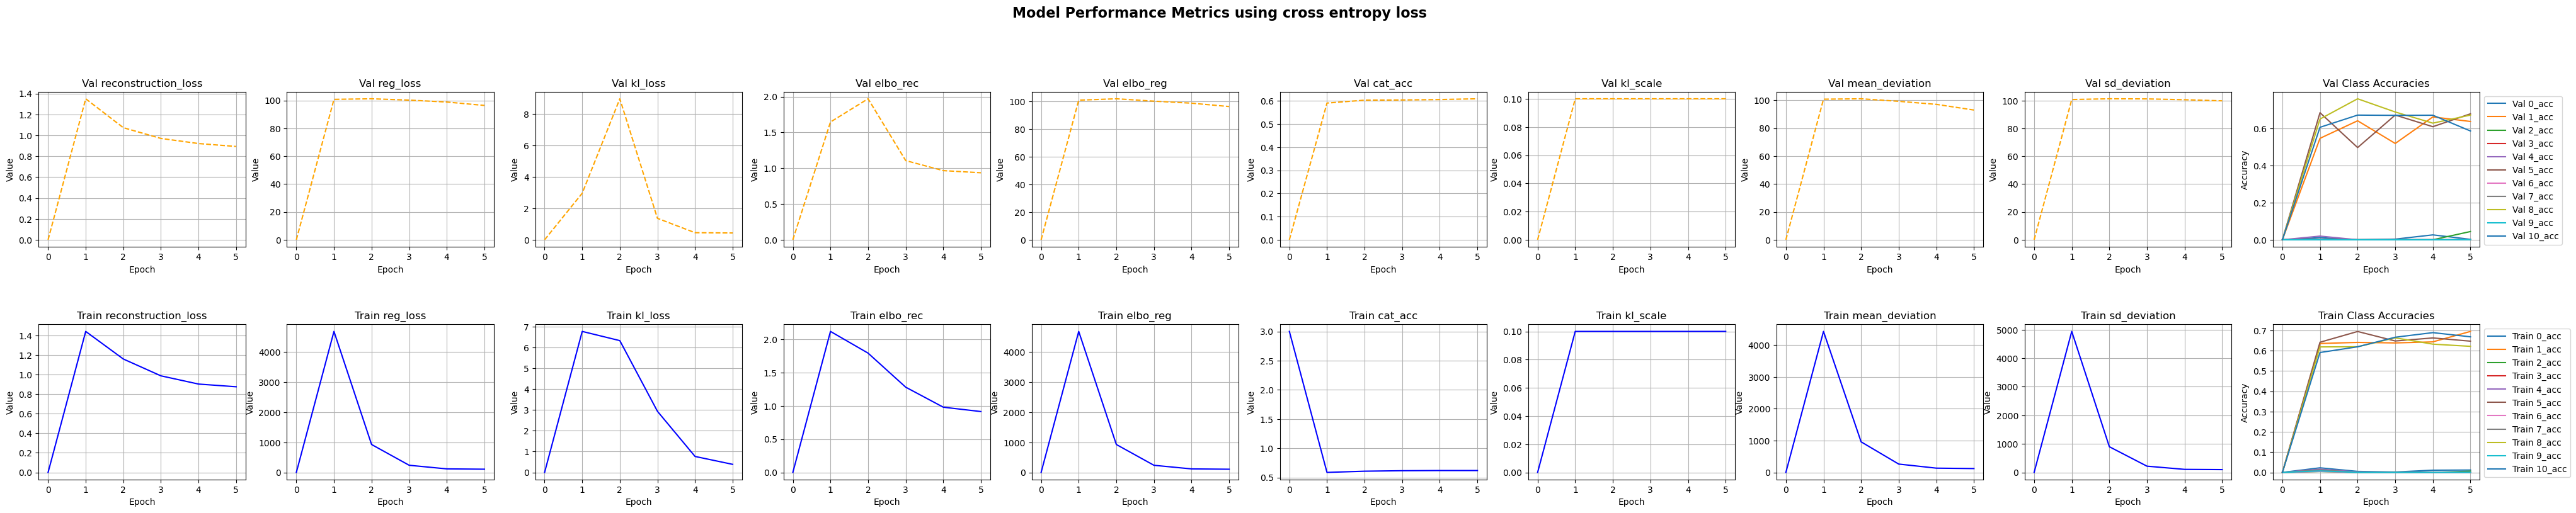

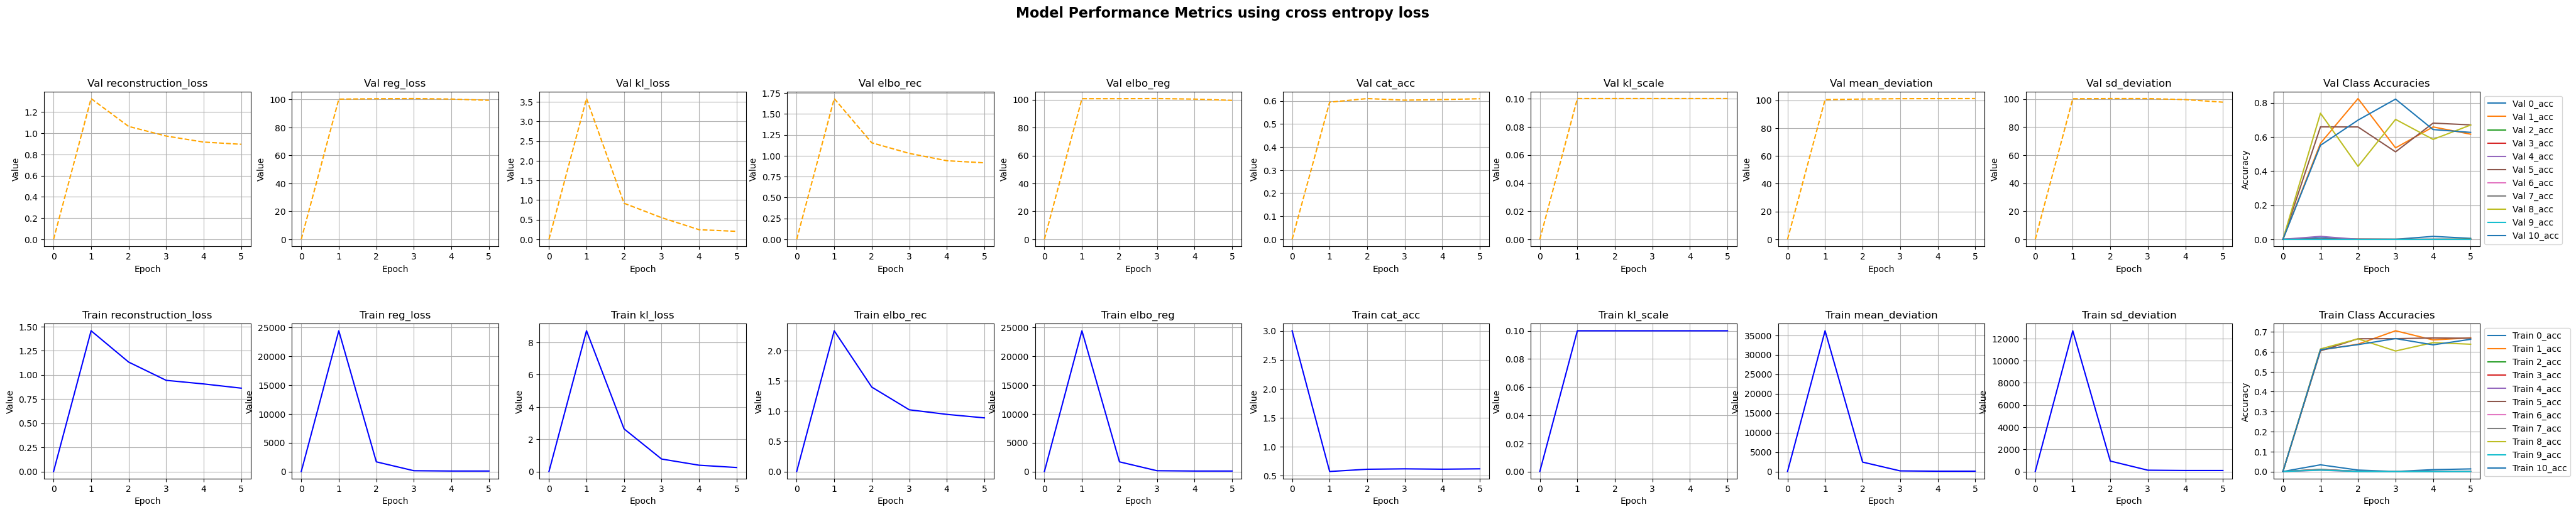

In [27]:
get_trait_performance("silk", rep_per_trait = 5, epochs = 5)